# Load dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir -p ./data/VNOnDB

In [ ]:
!unzip './drive/My Drive/VNOnDB/word_train.zip' -d ./data/VNOnDB >> log_extract.txt
print('Extracted word_train.zip')

Extracted word_train.zip


In [ ]:
!unzip './drive/My Drive/VNOnDB/word_val.zip' -d ./data/VNOnDB >> log_extract.txt
print('Extracted word_val.zip')

Extracted word_val.zip


In [ ]:
!unzip './drive/My Drive/VNOnDB/word_test.zip' -d ./data/VNOnDB >> log_extract.txt
print('Extracted word_test.zip')

In [ ]:
!cp './drive/My Drive/VNOnDB/train_word.csv' ./data/VNOnDB/
!cp './drive/My Drive/VNOnDB/test_word.csv' ./data/VNOnDB/
!cp './drive/My Drive/VNOnDB/validation_word.csv' ./data/VNOnDB/
print('Copied csv files')

Copied csv files


In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import math

import pdb

import pandas as pd

In [2]:
import skimage.io as io
from skimage.transform import rescale

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

In [4]:
def get_vietnamese_alphabets(is_include_space=False):
    lower_vowels_with_dm = u'áàảãạắằẳãặâấầẩẫậíìỉĩịúùủũụưứừửữựéèẻẽẹêếềểễệóòỏõọơớờởỡợôốồổỗộyýỳỷỹỵ'
    upper_vowels_with_dm = lower_vowels_with_dm.upper()
    lower_without_dm = u'abcdefghijklmnopqrstuvwxyzđ'
    upper_without_dm = lower_without_dm.upper()
    digits = '1234567890'
    
    if is_include_space:
        symbols = '?/*+-!,."\':;#%&()[] ' # including space character ' ' is using for line recognition only 
    else:
        symbols = '?/*+-!,."\':;#%&()[]' # including space character ' ' is using for line recognition only
    alphabets = lower_vowels_with_dm + lower_without_dm + upper_vowels_with_dm + upper_without_dm + digits + symbols
    return alphabets

In [5]:
class LabelEncoderDecoder:
    """
    Encode a string to one hot vectors and vice versa
    """
    def __init__(self, alphabets=None, eos_char=None, is_include_space=False):
        
        self.alphabets = alphabets or get_vietnamese_alphabets(is_include_space)
        self.eos_char = eos_char or '\n'    
        
        self.alphabets = self.alphabets + self.eos_char
        self.char_to_int = dict((c, i) for i, c in enumerate(self.alphabets))
        self.int_to_char = dict((i, c) for i, c in enumerate(self.alphabets))

    def encode(self, string):
        """
        Encode a string to one hot vector using alphabets
        """
        encoded_vectors = []
        for char in string:
            vector = [0]*len(self.alphabets)
            vector[self.char_to_int[char]] = 1
            encoded_vectors.append(vector)
        return np.array(encoded_vectors, dtype=int)

    def decode(self, vectors):
        string = ''.join(self.int_to_char[np.argmax(vector)] for vector in vectors)
        string = string.replace(self.eos_char, '')
        return string
    
label_encoder_decoder = LabelEncoderDecoder(get_vietnamese_alphabets(is_include_space=False), eos_char='\n', is_include_space=False)

In [6]:
# TODO: this is temporal for now, because line-level has less files than word-level, thus load faster.
# img_train_folder = './data/VNOnDB/line_train/'
# img_val_folder = './data/VNOnDB/line_val/'
# img_test_folder = './data/VNOnDB/line_test/'
train_folder = './data/VNOnDB/word_train/'
val_folder = './data/VNOnDB/word_val/'
test_folder = './data/VNOnDB/word_test/'

In [7]:
class VNOnDBDataset(Dataset):
    def __init__(self, root_dir, dataframe, transform=None):
        self.root_dir = root_dir
        
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.root_dir, self.df['id'][idx]+'.png')
        image = io.imread(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.df['label'][idx]
        label = label + label_encoder_decoder.eos_char
        label = label_encoder_decoder.encode(label)
            
        return image, label

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320, 480)),
#     transforms.Resize((8, 12)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

66991
torch.Size([1, 320, 480]) (5, 216)


'đáng'

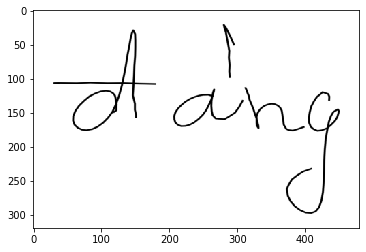

In [9]:
# TEST
mode = 'train'
level = 'word'

df = pd.read_csv(f'./data/VNOnDB/{mode}_{level}.csv', sep='\t', index_col=0)
print(len(df))
dataset = VNOnDBDataset(f'./data/VNOnDB/{level}_{mode}', df, transform)

X, y = dataset[803]
# plt.rcParams['figure.figsize'] = (2,1)
plt.imshow(torch.squeeze(X), cmap='gray')
print(X.shape, y.shape)
label_encoder_decoder.decode(y)

In [10]:
max_length = df['label'].astype(str).map(len).max()
max_length

11

# Model

In [28]:
# DenseNet: https://github.com/andreasveit/densenet-pytorch/blob/master/densenet.py

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet(nn.Module):
    def __init__(self, depth, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(1, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        # out = F.avg_pool2d(out, 8)
        return out

In [29]:
dense_growth_rate = 96
dense_depth = 4
densenet = DenseNet(dense_depth, dense_growth_rate)
print(densenet)

DenseNet(
  (conv1): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): DenseBlock(
    (layer): Sequential()
  )
  (trans1): TransitionBlock(
    (bn1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block2): DenseBlock(
    (layer): Sequential()
  )
  (trans2): TransitionBlock(
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (block3): DenseBlock(
    (layer): Sequential()
  )
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


In [30]:
class Attention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super(Attention, self).__init__()
    self.encoder_att = nn.Linear(encoder_dim, attention_dim)
    self.decoder_att = nn.Linear(decoder_dim, attention_dim)
    self.attn = nn.Linear(attention_dim, 1)

  def forward(self, decoder_hidden_state, encoder_outputs):
    '''
    encoder_outputs: [T, B, I]
    decoder_hidden_state: [num_layers*num_directions, B, H] = [1, B, H]
    '''
    # pdb.set_trace()
    att1 = self.encoder_att(encoder_outputs) # [T, B, A]
    att2 = self.decoder_att(decoder_hidden_state) # [1, B, A]
    att = self.attn(att1 + att2) # [T, B, 1]
    att = att.squeeze(2) # [T, B]
    
    weights = F.softmax(att, dim=0) # [T, B]
    
    weights = weights.unsqueeze(2) # [T, B, 1]

    context = weights * encoder_outputs

    # context: [T, B, H]
    # weights: [B, T, 1]
    return context, weights

In [31]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn = nn.GRU(self.input_size, self.hidden_size)

    def forward(self, input, hidden_state):
        return self.rnn(input, hidden_state)

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size).to(device)



In [32]:
class Model(nn.Module):
    def __init__(self, batch_size, hidden_size, vocab_size, dense_growth_rate=96, dense_depth=4):
        super(Model, self).__init__()
        self.batch_size = batch_size

        self.encoder = DenseNet(dense_depth, dense_growth_rate)
        self.input_size = self.encoder.in_planes

        self.attn = Attention(self.input_size, hidden_size, hidden_size)
        self.decoder = Decoder(self.input_size, hidden_size, batch_size)

        self.final = nn.Linear(hidden_size, vocab_size)

    def forward(self, batch_X, batch_Y):
        '''
        batch_X: [B, C, H, W]
        batch_Y: [T, B, V]
        '''


        encoder_outputs = self.encoder(batch_X) # [B, C, H*W]
        encoder_outputs = encoder_outputs.view(-1, self.batch_size, self.input_size) # [T, B, C], T = H*W

        decoder_hidden = self.decoder.init_hidden()
        decoder_outputs = []

        pdb.set_trace()

        for t in range(batch_Y.size(0)):
            y_t = batch_Y[t].unsqueeze(0) # [1, B, V]
            context, weights = self.attn(decoder_hidden, encoder_outputs)
            context = context.unsqueeze(0)
            decoder_output, decoder_hidden = self.decoder(context, decoder_hidden) # or groundtruth instead of context

            decoder_output = self.final(decoder_output)
            decoder_outputs.append(decoder_output)

        predict_Y = torch.cat(decoder_outputs, dim=0)
        return predict_Y

# Train

In [33]:
def batchize_labels(list_samples):
    list_image_sample = [sample[0] for sample in list_samples]
    list_label_sample = [torch.tensor(sample[1]) for sample in list_samples]
    
    batch_images = torch.stack(list_image_sample)
    batch_labels = torch.nn.utils.rnn.pad_sequence(list_label_sample)
    return batch_images, batch_labels

In [34]:
batch_size = 8
input_size = 9600 # temp
hidden_size = 256
seq_lens = 256 # TODO: = max len of all sequencs in dataset
vocab_size = len(label_encoder_decoder.alphabets)

learning_rate = 0.01

In [35]:
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=batchize_labels)

In [36]:
loader_iter = iter(train_loader)

In [37]:
batch_X, batch_y = next(loader_iter)
print(batch_X.shape, batch_y.shape)

torch.Size([8, 1, 320, 480]) torch.Size([6, 8, 216])


In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [39]:
model = Model(
    batch_size,
    hidden_size,
    vocab_size,
    dense_growth_rate,
    dense_depth
)

model = model.to(device)
x_train = batch_X.to(device)
y_train = batch_y.to(device)

In [40]:
predict_Y = model(x_train, y_train)

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 943718400 bytes. Error code 12 (Cannot allocate memory)
